In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')
dataset = 'drive/MyDrive/MortalityDATA.xlsx'
df = pd.read_excel(dataset)
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(91713, 85)

In [6]:
DM_df = df[df['diabetes_mellitus'] == 1]  #Selecting Only Diabetes
DM_df = DM_df.drop(['diabetes_mellitus'], axis=1)

In [7]:
DM_df = DM_df.drop(columns=[
    'encounter_id', 'icu_id', 'patient_id','hospital_id', #id
    'weight','height', #to BMI | there is no possible way to fill bmi with height and weight
    'Unnamed: 83', #null
    'ethnicity', #Sri lanka?
    'aids', 'lymphoma', 'cirrhosis','leukemia','hepatic_failure','immunosuppression','solid_tumor_with_metastasis' #less contributing diseases
    ])

In [8]:
DM_df = DM_df.drop(columns=[ #noninvasive remove according to Domain Expert
                            'd1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min',
                            'd1_mbp_noninvasive_max','d1_mbp_noninvasive_min',
                             'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
                             'h1_diasbp_noninvasive_max','h1_diasbp_noninvasive_min',
                             'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
                             'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min'
    ])

In [9]:
X = DM_df.copy()
y = X['hospital_death']  #target variable
X = X.drop(['hospital_death'], axis=1)
X.shape

(20492, 56)

In [13]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['icu_type','gender', 'icu_stay_type','icu_admit_source','apache_3j_bodysystem','apache_2_bodysystem']

label_encoder = LabelEncoder()
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

Removing Less Contributing Features by considering feature importance (<1%)

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X, y)

#feature importances
feature_importances = rf_model.feature_importances_*100

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
features_to_drop = feature_importance_df[feature_importance_df['Importance'] < 1]['Feature'].tolist()


Xdroped = X.drop(columns=features_to_drop)
features_to_drop

['gcs_verbal_apache',
 'icu_type',
 'apache_3j_bodysystem',
 'ventilated_apache',
 'icu_admit_source',
 'd1_spo2_max',
 'apache_2_bodysystem',
 'intubated_apache',
 'gender',
 'arf_apache',
 'icu_stay_type',
 'elective_surgery',
 'apache_post_operative',
 'gcs_unable_apache']

All categorical Values got dropped

In [16]:
Xdroped_2 = Xdroped.drop(columns=['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob']) # These are similar to what we want to achieve
Xdroped_2.shape

(20492, 40)

In [17]:
# apache score drop | Dropped by the suggestion of Domain Expert
Xdroped_3 = Xdroped_2.drop(columns=['gcs_motor_apache','resprate_apache','heart_rate_apache','temp_apache','gcs_eyes_apache',
                                      'map_apache','heart_rate_apache','apache_3j_diagnosis','apache_2_diagnosis','resprate_apache'
                                      ])
Xdroped_3.shape

(20492, 32)

In [56]:
Xdroped_3.columns

Index(['age', 'bmi', 'pre_icu_los_days', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max',
       'h1_mbp_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max',
       'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'd1_glucose_max',
       'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min'],
      dtype='object')

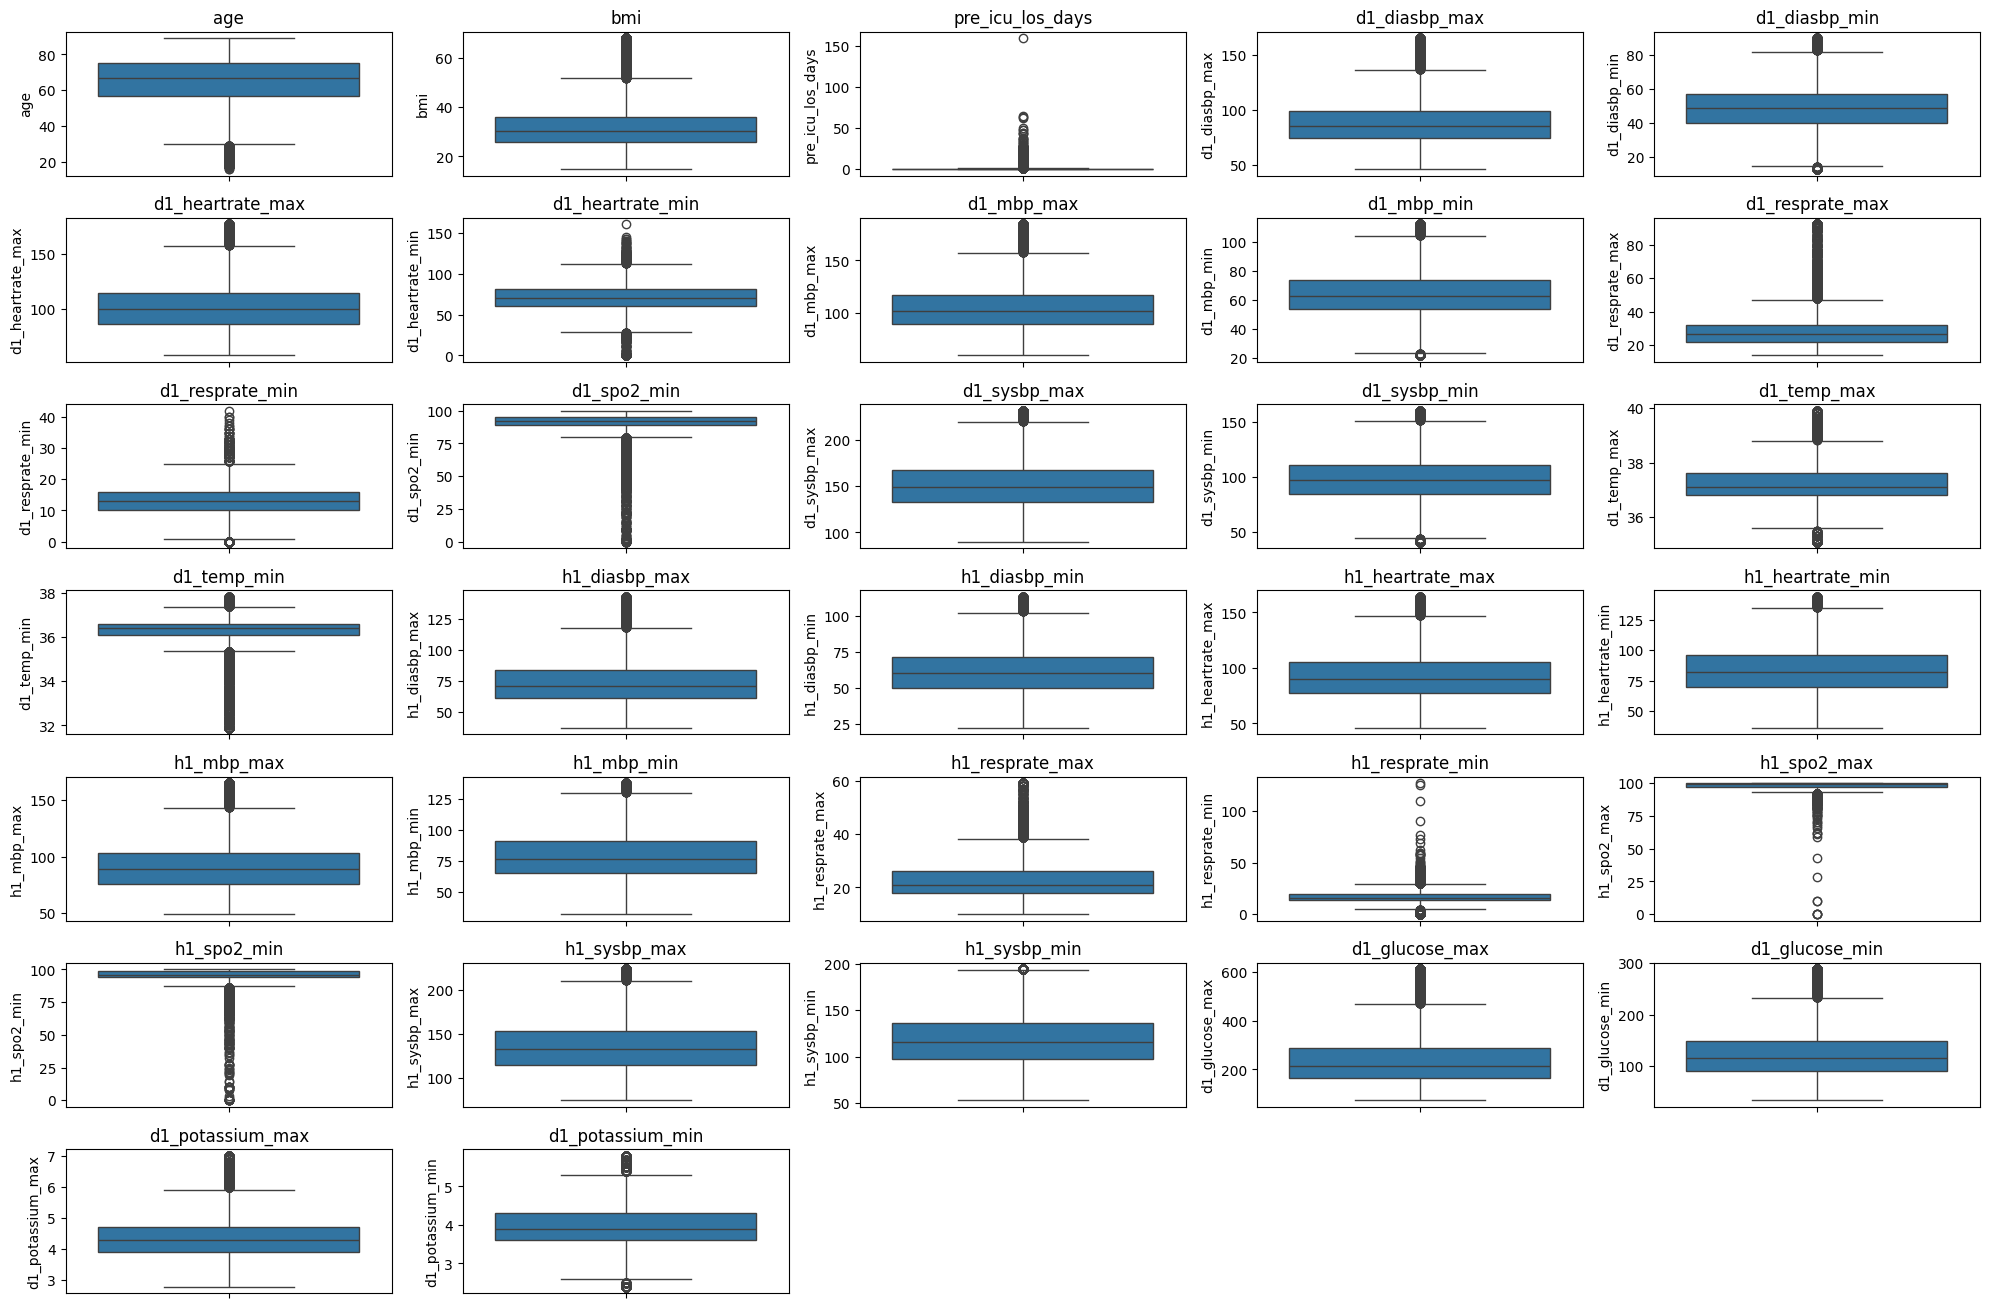

In [18]:
# Boxplots for all columns in Xdroped_3
plt.figure(figsize=(20, 15))
for i, col in enumerate(Xdroped_3.columns):
    plt.subplot(8, 5, i + 1)
    sns.boxplot(y=Xdroped_3[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

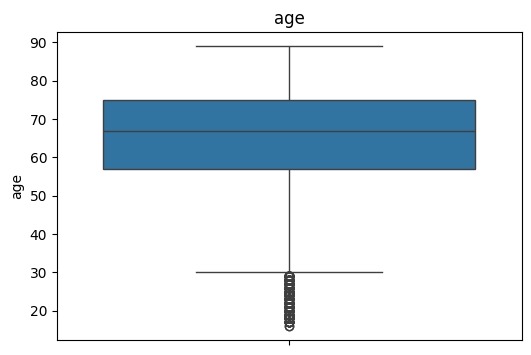

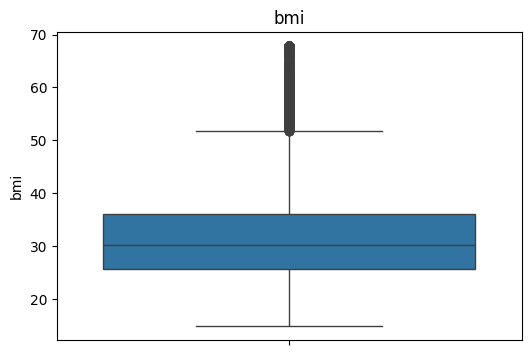

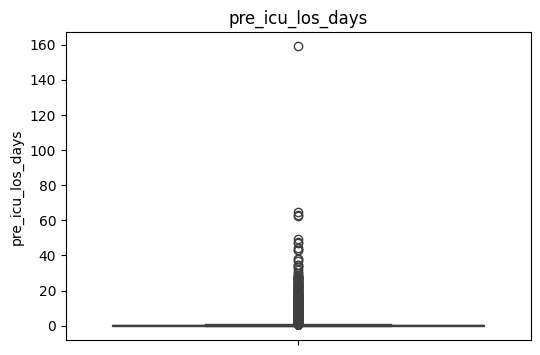

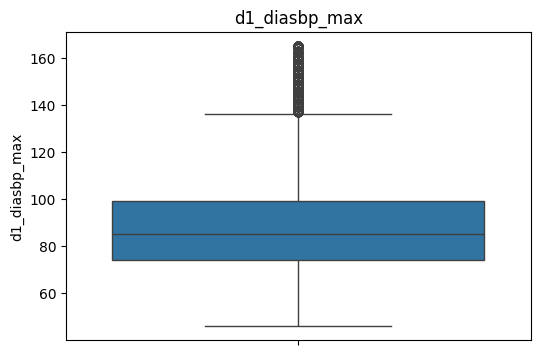

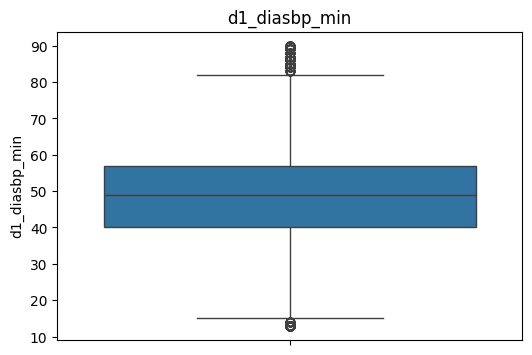

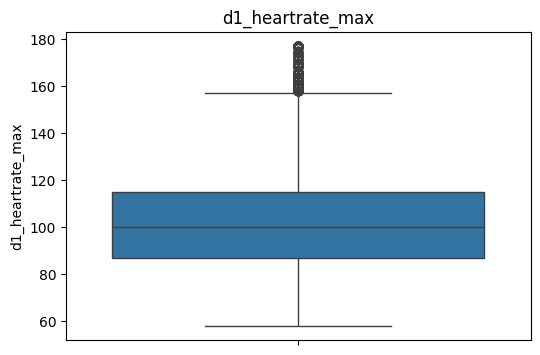

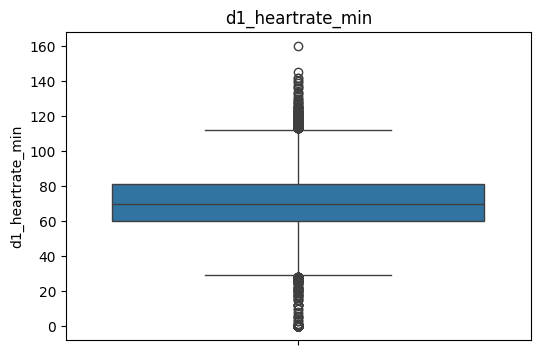

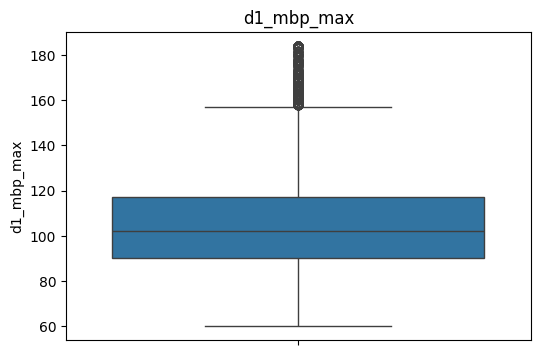

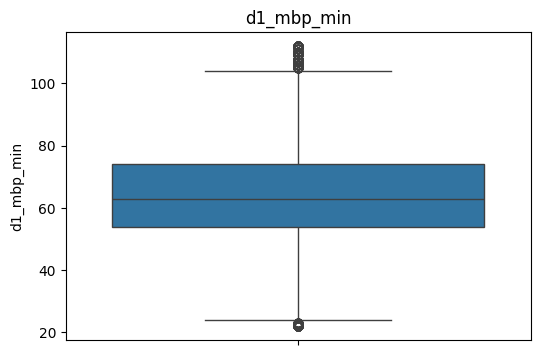

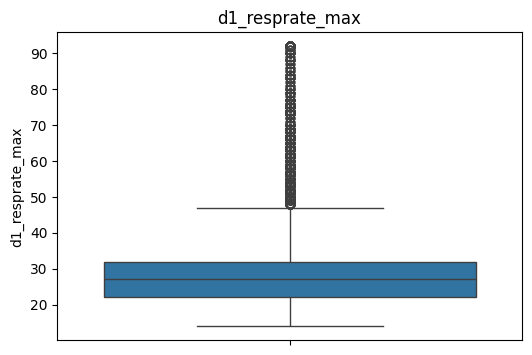

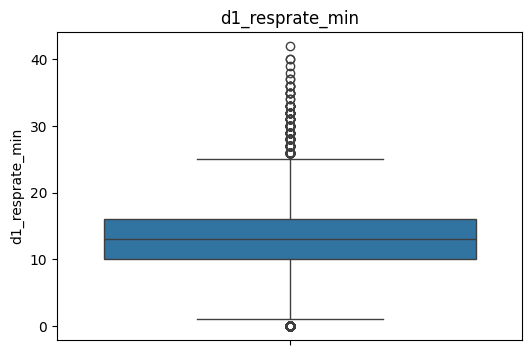

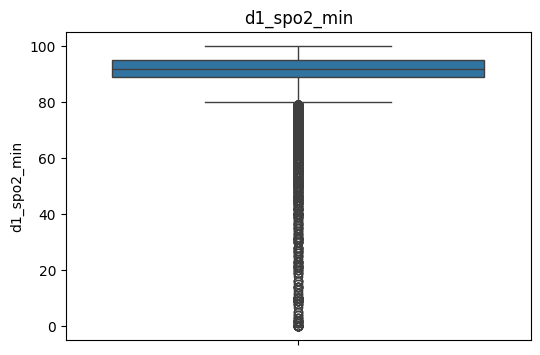

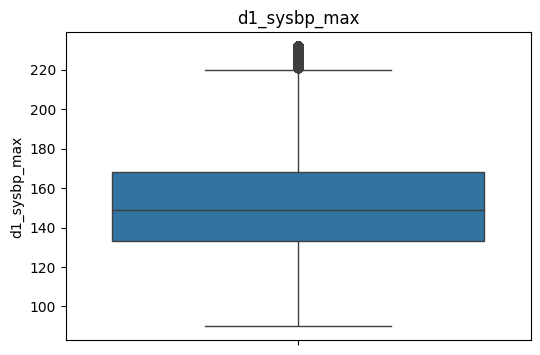

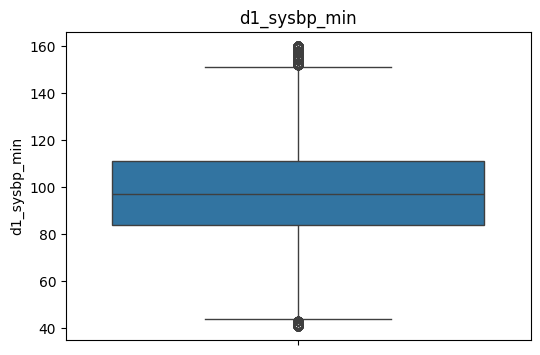

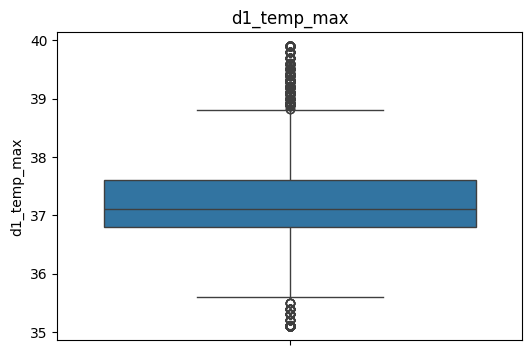

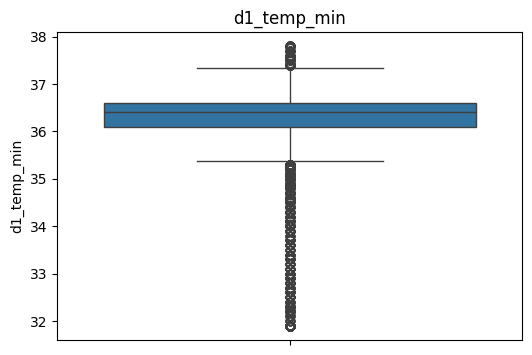

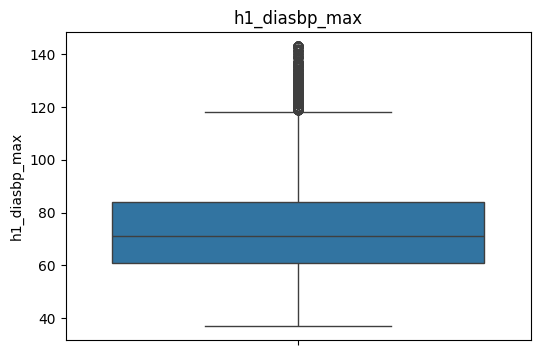

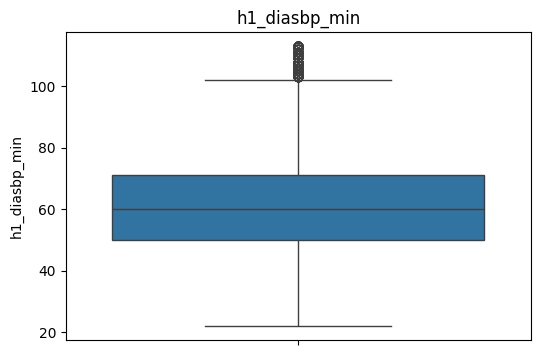

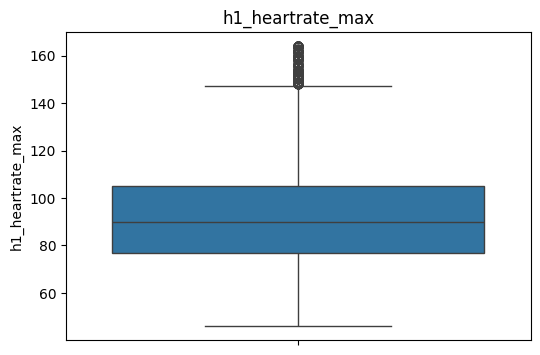

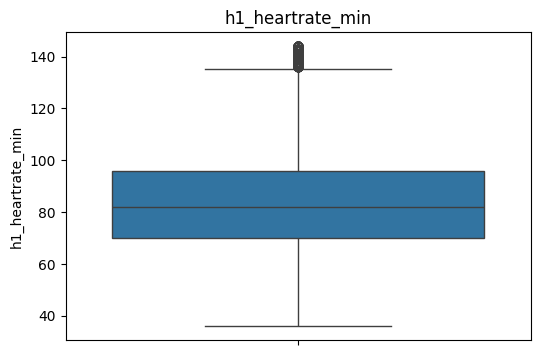

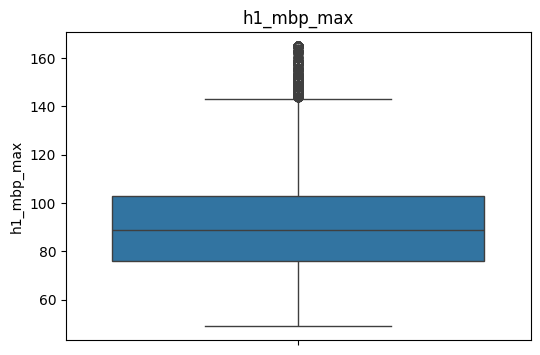

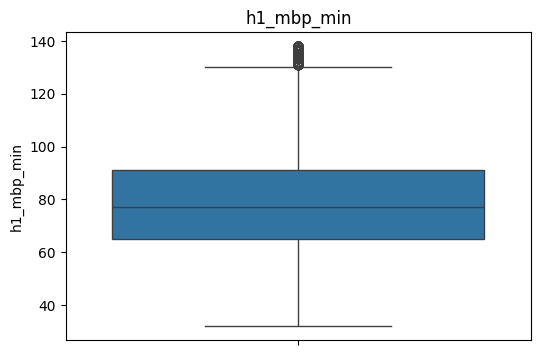

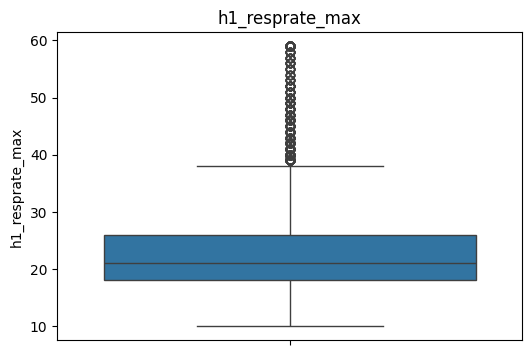

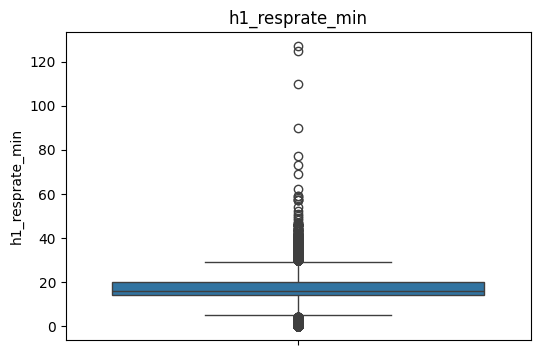

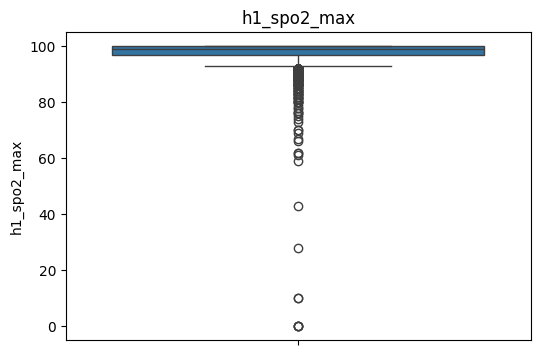

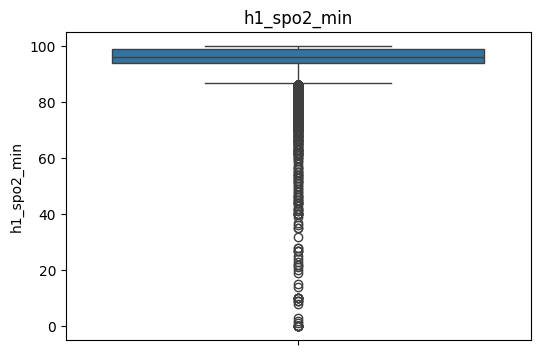

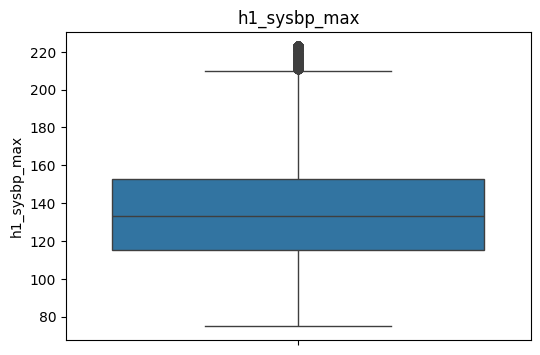

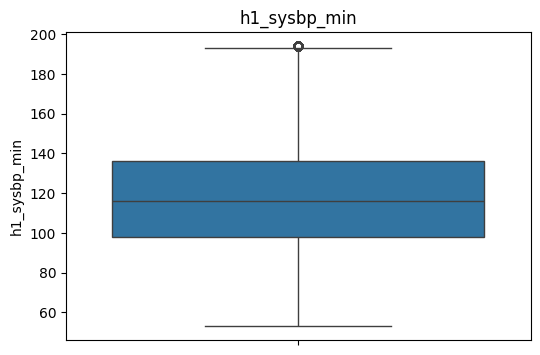

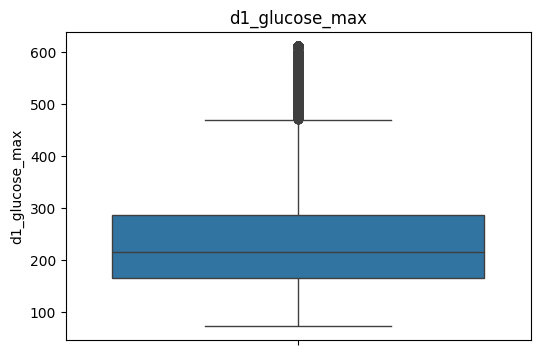

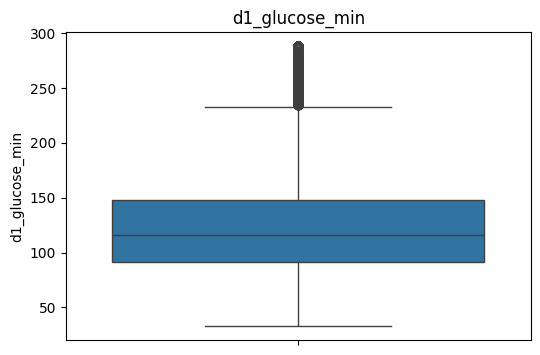

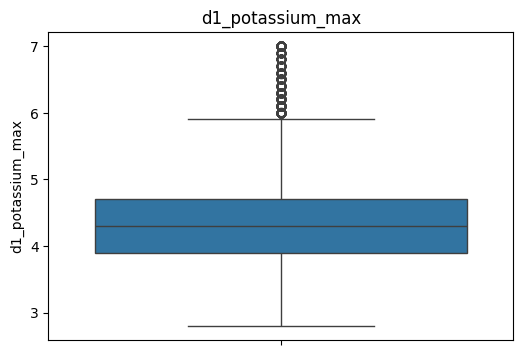

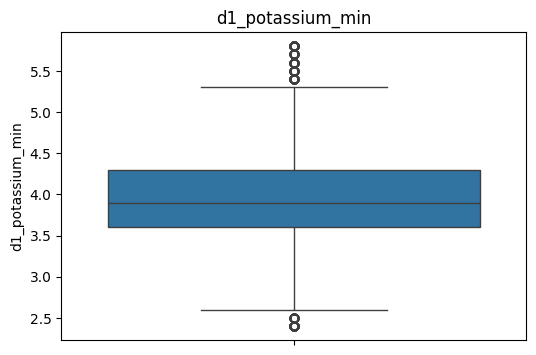

In [37]:
#separate box plots for each column to make them easier to view
for col in Xdroped_3.columns:
  plt.figure(figsize=(6, 4))
  sns.boxplot(y=Xdroped_3[col])
  plt.title(col)
  plt.show()
  print()

In [20]:
merged_df = pd.concat([Xdroped_3, y], axis=1)

In [49]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20414 entries, 0 to 91710
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               20414 non-null  int64  
 1   bmi               20414 non-null  float64
 2   pre_icu_los_days  20414 non-null  float64
 3   d1_diasbp_max     20414 non-null  float64
 4   d1_diasbp_min     20414 non-null  float64
 5   d1_heartrate_max  20414 non-null  float64
 6   d1_heartrate_min  20414 non-null  float64
 7   d1_mbp_max        20414 non-null  float64
 8   d1_mbp_min        20414 non-null  float64
 9   d1_resprate_max   20414 non-null  float64
 10  d1_resprate_min   20414 non-null  float64
 11  d1_spo2_min       20414 non-null  float64
 12  d1_sysbp_max      20414 non-null  float64
 13  d1_sysbp_min      20414 non-null  float64
 14  d1_temp_max       20414 non-null  float64
 15  d1_temp_min       20414 non-null  float64
 16  h1_diasbp_max     20414 non-null  float64
 17

In [38]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20414.0,64.688057,14.205526,16.000000,57.000000,66.000000,75.000000,89.000000
bmi,20414.0,31.829806,8.824202,14.844926,25.845717,30.636206,35.825859,67.814990
pre_icu_los_days,20414.0,0.945259,2.807559,0.000000,0.042361,0.153472,0.471528,159.090972
d1_diasbp_max,20414.0,87.795845,20.300635,46.000000,74.000000,86.000000,99.000000,165.000000
d1_diasbp_min,20414.0,48.840826,12.974974,13.000000,40.000000,49.000000,57.000000,90.000000
d1_heartrate_max,20414.0,102.098682,21.255092,58.000000,87.000000,100.000000,115.000000,177.000000
d1_heartrate_min,20414.0,70.916152,16.754616,0.000000,60.000000,70.000000,81.000000,160.000000
d1_mbp_max,20414.0,105.350807,21.435305,60.000000,90.000000,102.000000,117.000000,184.000000
d1_mbp_min,20414.0,64.269467,15.718668,22.000000,54.000000,63.000000,74.000000,112.000000
d1_resprate_max,20414.0,29.007920,10.720461,14.000000,22.000000,27.000000,32.000000,92.000000


In [39]:
merged_df.isnull().sum()

,0
age,0
bmi,0
pre_icu_los_days,0
d1_diasbp_max,0
d1_diasbp_min,0
d1_heartrate_max,0
d1_heartrate_min,0
d1_mbp_max,0
d1_mbp_min,0
d1_resprate_max,0


### pre_icu_los_days (negative)

In [40]:
#negative values in 'pre_icu_los_days'
negative_count = (merged_df['pre_icu_los_days'] < 0).sum()
print(f"Number of negative values in 'pre_icu_los_days': {negative_count}")
print(merged_df.shape)
#Remove rows
merged_df = merged_df[merged_df['pre_icu_los_days'] >= 0]
merged_df.shape

Number of negative values in 'pre_icu_los_days': 0
(20414, 33)


(20414, 33)

### Null handling

In [57]:
def fill_with_mean(df, features):

  """Fills NaN values in specified features with their respective means.

  Args:
    df: The pandas DataFrame.
    features: A list of feature names to process.

  Returns:
    The DataFrame with NaN values filled.
  """

  for feature in features:
    if feature in df.columns:
      mean_value = df[feature].mean()
      df[feature] = df[feature].fillna(mean_value)
  return df

# age and bmi
merged_df = fill_with_mean(merged_df, ['age', 'bmi'])

In [58]:
def fill_null_by_group(df, feature, group_column='hospital_death'):

    """
    Fills null values in a specified feature based on the mean of the feature for each group defined by the group_column.

    Args:
        df: The input DataFrame.
        feature: The name of the feature column to fill null values.
        group_column: The name of the column to group by (default: 'hospital_death').
    Returns:
        DataFrame with nulls filled
    """

    #mean of the feature for each group
    feature_mean_death = df[df[group_column] == 1][feature].w()
    feature_mean_alive = df[df[group_column] == 0][feature].mean()

    #Fill null values in the feature based on the group
    df.loc[df[group_column] == 1, feature] = df.loc[df[group_column] == 1, feature].fillna(feature_mean_death)
    df.loc[df[group_column] == 0, feature] = df.loc[df[group_column] == 0, feature].fillna(feature_mean_alive)
    return df

In [59]:
h1_cols = [col for col in merged_df.columns if col.startswith('h1_')]
d1_cols = [col for col in merged_df.columns if col.startswith('d1_')]

for col in h1_cols + d1_cols:
    merged_df = fill_null_by_group(merged_df, col)

In [60]:
merged_df.isnull().sum()

,0
age,0
bmi,0
pre_icu_los_days,0
d1_diasbp_max,0
d1_diasbp_min,0
d1_heartrate_max,0
d1_heartrate_min,0
d1_mbp_max,0
d1_mbp_min,0
d1_resprate_max,0


In [61]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20414.0,64.688057,14.205526,16.000000,57.000000,66.000000,75.000000,89.000000
bmi,20414.0,31.829806,8.824202,14.844926,25.845717,30.636206,35.825859,67.814990
pre_icu_los_days,20414.0,0.945259,2.807559,0.000000,0.042361,0.153472,0.471528,159.090972
d1_diasbp_max,20414.0,87.795845,20.300635,46.000000,74.000000,86.000000,99.000000,165.000000
d1_diasbp_min,20414.0,48.840826,12.974974,13.000000,40.000000,49.000000,57.000000,90.000000
d1_heartrate_max,20414.0,102.098682,21.255092,58.000000,87.000000,100.000000,115.000000,177.000000
d1_heartrate_min,20414.0,70.916152,16.754616,0.000000,60.000000,70.000000,81.000000,160.000000
d1_mbp_max,20414.0,105.350807,21.435305,60.000000,90.000000,102.000000,117.000000,184.000000
d1_mbp_min,20414.0,64.269467,15.718668,22.000000,54.000000,63.000000,74.000000,112.000000
d1_resprate_max,20414.0,29.007920,10.720461,14.000000,22.000000,27.000000,32.000000,92.000000


In [54]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20414 entries, 0 to 91710
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               20414 non-null  int64  
 1   bmi               20414 non-null  float64
 2   pre_icu_los_days  20414 non-null  float64
 3   d1_diasbp_max     20414 non-null  float64
 4   d1_diasbp_min     20414 non-null  float64
 5   d1_heartrate_max  20414 non-null  float64
 6   d1_heartrate_min  20414 non-null  float64
 7   d1_mbp_max        20414 non-null  float64
 8   d1_mbp_min        20414 non-null  float64
 9   d1_resprate_max   20414 non-null  float64
 10  d1_resprate_min   20414 non-null  float64
 11  d1_spo2_min       20414 non-null  float64
 12  d1_sysbp_max      20414 non-null  float64
 13  d1_sysbp_min      20414 non-null  float64
 14  d1_temp_max       20414 non-null  float64
 15  d1_temp_min       20414 non-null  float64
 16  h1_diasbp_max     20414 non-null  float64
 17

In [62]:
merged_df.to_excel('Preprocessed_data3.xlsx', index=False)  #index=False to avoid saving the index

from google.colab import files
files.download('Preprocessed_data3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
merged_df.head(50)

,age,bmi,pre_icu_los_days,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,...,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,hospital_death
0,68,22.730000,0.541667,68.0,37.0,119.0,72.0,89.0,46.0,34.0,...,18.000000,100.0,74.0,131.0,115.0,168.0,109.0,4.000000,3.400000,0
1,77,27.420000,0.927778,95.0,31.0,118.0,72.0,120.0,38.0,32.0,...,28.000000,95.0,70.0,95.0,71.0,145.0,128.0,4.200000,3.800000,0
5,67,27.560000,0.000694,100.0,61.0,113.0,83.0,127.0,80.0,32.0,...,12.000000,97.0,97.0,143.0,143.0,156.0,125.0,3.900000,3.700000,0
6,59,57.450000,0.000694,76.0,68.0,112.0,70.0,117.0,97.0,38.0,...,18.000000,100.0,100.0,191.0,163.0,197.0,129.0,5.000000,4.200000,0
15,78,31.829806,0.000694,70.0,43.0,82.0,68.0,118.0,64.0,22.0,...,17.000000,100.0,95.0,119.0,89.0,109.0,90.0,5.500000,5.500000,0
21,80,35.659989,0.000694,96.0,49.0,102.0,70.0,111.0,64.0,40.0,...,16.990575,98.0,96.0,164.0,126.0,316.0,256.0,4.100000,3.700000,0
28,64,31.829806,1.031944,56.0,34.0,177.0,76.0,92.0,56.0,20.0,...,14.000000,100.0,99.0,154.0,154.0,208.0,171.0,4.500000,3.400000,0
31,68,27.560503,0.005556,80.0,51.0,90.0,57.0,123.0,73.0,39.0,...,9.000000,100.0,99.0,176.0,119.0,216.0,82.0,4.100000,4.100000,0
35,71,38.497016,0.000694,105.0,51.0,96.0,70.0,137.0,76.0,59.0,...,28.000000,97.0,97.0,163.0,136.0,198.0,158.0,3.700000,3.700000,0
41,60,31.829806,0.008333,76.0,38.0,136.0,77.0,93.0,49.0,46.0,...,20.000000,100.0,93.0,93.0,68.0,611.0,170.0,4.000000,2.800000,0
